사용할 CSV 파일: /Users/parkhyunsik/.cache/kagglehub/datasets/gomjellie/kospi-price-data/versions/1/kospi/017960.csv

--- 예측력(Predictive) MAE 결과 (Lower is Better) ---
※ 예측: '전날의 EWMA'로 '오늘의 Close'를 예측
Span 1: Predictive MAE = 55.1724
Span 2: Predictive MAE = 54.1039
Span 3: Predictive MAE = 56.2206
Span 4: Predictive MAE = 58.6342
Span 5: Predictive MAE = 62.1271
Span 6: Predictive MAE = 65.2333
Span 7: Predictive MAE = 67.6918
Span 8: Predictive MAE = 69.6896
Span 9: Predictive MAE = 71.3433
Span 10: Predictive MAE = 72.7291

🏆 최적의 예측 Span: 2 (MAE: 54.1039)


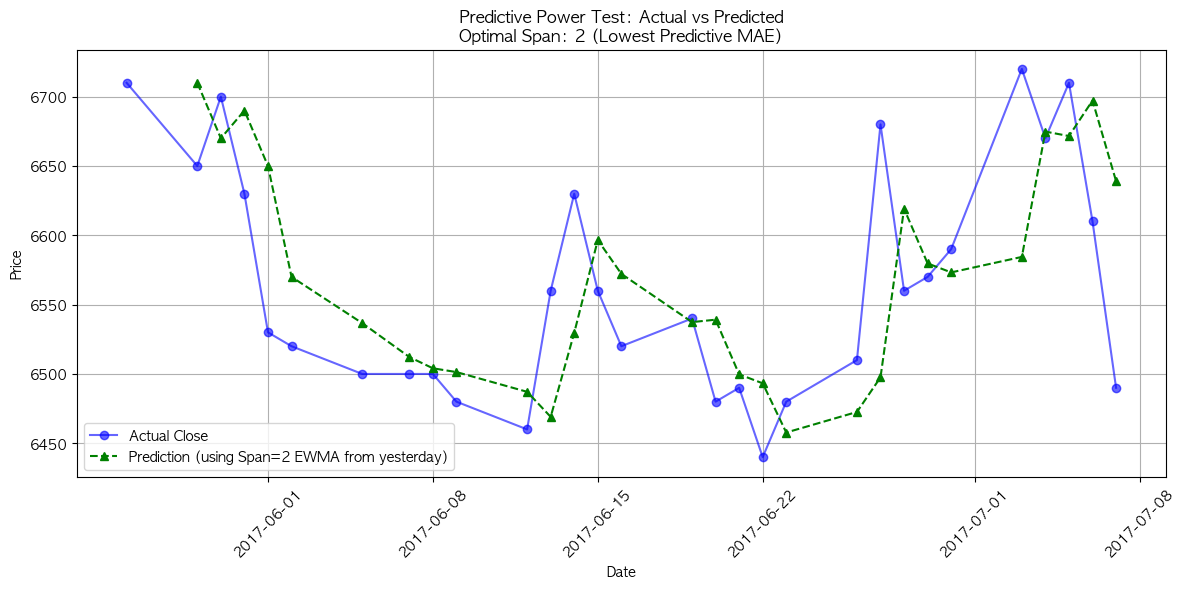


--- Data Check (Actual vs Predicted) ---
             Close  Pred_Span_2
Date                           
2017-07-03  6720.0  6584.413917
2017-07-04  6670.0  6674.804639
2017-07-05  6710.0  6671.601546
2017-07-06  6610.0  6697.200515
2017-07-07  6490.0  6639.066838


In [32]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import kagglehub
from sklearn.metrics import mean_absolute_error
import numpy as np

# 한글 폰트 설정 (Mac)
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

# 1. 데이터 다운로드 및 CSV 파일 찾기
try:
    path = kagglehub.dataset_download("gomjellie/kospi-price-data")
    
    csv_file_path = None
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith('.csv'):
                csv_file_path = os.path.join(root, file)
                break
        if csv_file_path:
            break
            
    if csv_file_path:
        print(f"사용할 CSV 파일: {csv_file_path}")
        
        # 2. 데이터 로드
        df = pd.read_csv(csv_file_path)
        
        if 'Date' in df.columns:
            df['Date'] = pd.to_datetime(df['Date'])
            df.set_index('Date', inplace=True)
        
        df.sort_index(inplace=True)
        
        # 3. 마지막 20개 행 추출
        last_20 = df.iloc[-30:].copy()
        
        # 4. [예측력 테스트] Span 1~10에 대해 '내일의 주가' 예측 오차 계산
        # EWMA_Predict = (어제의 EWMA) -> (오늘의 Close 예측)
        
        best_pred_mae = float('inf')
        best_pred_span = 0
        
        print("\n--- 예측력(Predictive) MAE 결과 (Lower is Better) ---")
        print("※ 예측: '전날의 EWMA'로 '오늘의 Close'를 예측")
        
        for span in range(1, 11):
            # 1. EWMA 계산
            ewma_col = f'EWMA_{span}'
            last_20[ewma_col] = last_20['Close'].ewm(span=span, adjust=False).mean()
            
            # 2. Shift를 통해 '어제의 EWMA'를 가져옴
            pred_col = f'Pred_Span_{span}'
            last_20[pred_col] = last_20[ewma_col].shift(1)
            
            # 3. 첫 번째 행은 Shift로 인해 NaN이 되므로 제외하고 MAE 계산
            valid_rows = last_20.dropna(subset=[pred_col])
            
            if not valid_rows.empty:
                mae = mean_absolute_error(valid_rows['Close'], valid_rows[pred_col])
                print(f"Span {span}: Predictive MAE = {mae:.4f}")
                
                if mae < best_pred_mae:
                    best_pred_mae = mae
                    best_pred_span = span
        
        print(f"\n🏆 최적의 예측 Span: {best_pred_span} (MAE: {best_pred_mae:.4f})")
        # 참고: Span이 낮을수록 '현재 추세'를 빨리 반영하지만, 너무 낮으면 '노이즈'까지 따라가서 예측력이 떨어질 수 있음.
        
        # 5. 최적 예측 Span 그래프 그리기
        plt.figure(figsize=(12, 6))
        plt.plot(last_20.index, last_20['Close'], marker='o', label='Actual Close', color='blue', alpha=0.6)
        
        best_pred_col = f'Pred_Span_{best_pred_span}'
        # 그래프에서는 '예측값'을 보여줌 (어제의 EWMA)
        plt.plot(last_20.index, last_20[best_pred_col], color='green', linestyle='--', marker='^', 
                 label=f'Prediction (using Span={best_pred_span} EWMA from yesterday)')
        
        plt.title(f'Predictive Power Test: Actual vs Predicted\nOptimal Span: {best_pred_span} (Lowest Predictive MAE)')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
        print("\n--- Data Check (Actual vs Predicted) ---")
        print(last_20[['Close', best_pred_col]].tail())
        
    else:
        print("CSV 파일을 찾을 수 없습니다.")
        
except Exception as e:
    print(f"오류 발생: {e}")